# Demo: 5x6mm Bi-hemispheric FOV
Estimating the reliable dimensionality of neuronal population dynamics as a function of neuron number

This example will walk you through a number of analyses from [Manley et al. _Neuron_ 2024](https://doi.org/10.1016/j.neuron.2024.02.011).
Namely:

1. Utilizing SVCA to estimate the reliable dimensionality of neuronal population dynamics as a function of neuron number
2. Predicting neural SVC dimensions from behavioral variables
3. Quantifying the timescales of neural SVC dimensions
4. Quantifying the spatial distribution of neural SVC dimensions

The data analyzed here are freely available at https://doi.org/10.5281/zenodo.10403684.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
#from rastermap import Rastermap
from scipy.stats import zscore
from tqdm import tqdm
import warnings
warnings.simplefilter("ignore")

import scaling_analysis as sa
from scaling_analysis.experiment import Experiment
from scaling_analysis.plotting import set_my_rcParams, plot_MIPs, plot_neurons_behavior, calc_var_expl
from scaling_analysis.predict import predict_from_behavior
from scaling_analysis.spatial import local_homogeneity
from scaling_analysis.temporal import compute_timescales

set_my_rcParams()

The `Experiment` class loads the example .h5 files provided.

In [2]:
path = "/mnt/smb/locker/litwin-kumar-locker/om2382/neural_data_sensorimotor/"
file = "spont_D9_2021_11_22_2.npz"
data = np.load(os.path.join(path, file))#"spont_D9_2021_11_22_2.npz")

# Print out the names of arrays stored in the file
print("Arrays in the file:", data.files)

# Optionally, inspect the shape and data type of each array
for key in data.files:
    print(f"Array '{key}': shape {data[key].shape}, dtype {data[key].dtype}")
#expt = Experiment(os.path.join(path, file))

Arrays in the file: ['xpos', 'ypos', 'spks', 'run', 'tcam', 'tneural']
Array 'xpos': shape (24708,), dtype float64
Array 'ypos': shape (24708,), dtype float64
Array 'spks': shape (24708, 23586), dtype float32
Array 'run': shape (23586,), dtype float64
Array 'tcam': shape (329361,), dtype float64
Array 'tneural': shape (23586,), dtype float64


In [20]:
import numpy as np

# ============================================================
# Function: fast SVCA on an already time-subsampled matrix
# ============================================================
def fast_svca(
    X_sub,          # (N, T_sub) neurons × time (already time-subsampled)
    idxA, idxB,     # neuron indices for the two halves (fixed across runs)
    *,              # keyword-only after this
    nblocks=10,     # interleaved blocks within X_sub for CV split
    pA=512, pB=512, # optional PCA dims (None => no compression)
    r_max=256,      # cap #components scored (None => all)
    dtype=np.float32
):
    """
    Returns
    -------
    s_shared : (r,)  cross-validated shared variance per component (test)
    s_total  : (r,)  total variance per component (test)
    Notes
    -----
    - X_sub is already the chosen time subset (e.g., one contiguous chunk or salt-pepper mix).
    - This function only does train/test splitting within X_sub, plus the SVCA scoring.
    - Uses float32 internally for speed/memory; returns float64 outputs.
    """
    assert X_sub.ndim == 2
    N, Tsub = X_sub.shape
    if Tsub < nblocks:
        raise ValueError("nblocks exceeds number of available timepoints in X_sub")

    # cast dtype for speed
    if X_sub.dtype != dtype:
        X_sub = X_sub.astype(dtype, copy=False)

    # interleaved train/test within X_sub columns
    edges = np.linspace(0, Tsub, nblocks + 1, dtype=int)
    train_blocks = np.arange(0, nblocks, 2)
    test_blocks  = np.arange(1, nblocks, 2)
    itrain = np.concatenate([np.arange(edges[b], edges[b+1]) for b in train_blocks])
    itest  = np.concatenate([np.arange(edges[b], edges[b+1]) for b in test_blocks])
    Ttr, Tte = itrain.size, itest.size
    if Ttr == 0 or Tte == 0:
        raise ValueError("Train/test split produced empty sets; reduce nblocks.")

    # neuron splits
    XA = X_sub[idxA]  # (nA, Tsub)
    XB = X_sub[idxB]  # (nB, Tsub)
    nA, nB = XA.shape[0], XB.shape[0]

    # center by train mean (no leakage)
    muA = XA[:, itrain].mean(axis=1, keepdims=True)
    muB = XB[:, itrain].mean(axis=1, keepdims=True)
    XA_tr, XA_te = XA[:, itrain] - muA, XA[:, itest] - muA
    XB_tr, XB_te = XB[:, itrain] - muB, XB[:, itest] - muB

    # optional PCA compression (fit on train, apply to test)
    def pca_project(Xtr, Xte, p_keep):
        if (p_keep is None):
            return Xtr, Xte, None
        p_cap = int(min(p_keep, Xtr.shape[0], Xtr.shape[1]))
        if p_cap <= 0 or p_cap >= min(Xtr.shape):
            return Xtr, Xte, None
        U, S, Vt = np.linalg.svd(Xtr, full_matrices=False)  # Xtr = U S V^T
        U = U[:, :p_cap].astype(Xtr.dtype, copy=False)
        return U.T @ Xtr, U.T @ Xte, U

    XA_tr_p, XA_te_p, UA = pca_project(XA_tr, XA_te, pA)
    XB_tr_p, XB_te_p, UB = pca_project(XB_tr, XB_te, pB)
    nA_eff, nB_eff = XA_tr_p.shape[0], XB_tr_p.shape[0]

    # cross-cov on train
    scale_tr = np.float32(1.0 / max(Ttr - 1, 1))
    CAB_tr = (XA_tr_p @ XB_tr_p.T) * scale_tr  # (nA_eff, nB_eff)

    # fast SVD via eigen on the smaller side
    if nA_eff <= nB_eff:
        G = CAB_tr @ CAB_tr.T
        w, U_p = np.linalg.eigh(G)        # ascending
        s = np.sqrt(np.clip(w, 0, None))
        order = np.argsort(s)[::-1]
        s = s[order]; U_p = U_p[:, order]
        if r_max is not None:
            r = int(min(r_max, s.size))
            s, U_p = s[:r], U_p[:, :r]
        eps = np.finfo(CAB_tr.dtype).eps
        V_p = (CAB_tr.T @ U_p) / (s[None, :] + eps)
    else:
        G = CAB_tr.T @ CAB_tr
        w, V_p = np.linalg.eigh(G)
        s = np.sqrt(np.clip(w, 0, None))
        order = np.argsort(s)[::-1]
        s = s[order]; V_p = V_p[:, order]
        if r_max is not None:
            r = int(min(r_max, s.size))
            s, V_p = s[:r], V_p[:, :r]
        eps = np.finfo(CAB_tr.dtype).eps
        U_p = (CAB_tr @ V_p) / (s[None, :] + eps)

    r = s.size

    # vectorized CV scoring on test
    scale_te = np.float32(1.0 / max(Tte - 1, 1))
    A = U_p.T @ XA_te_p          # (r, Tte)
    B = V_p.T @ XB_te_p          # (r, Tte)
    s_shared = np.einsum('ik,ik->i', A, B) * scale_te
    AA = np.einsum('ik,ik->i', A, A)
    BB = np.einsum('ik,ik->i', B, B)
    s_total = 0.5 * (AA + BB) * scale_te

    return s_shared.astype(np.float64, copy=False), s_total.astype(np.float64, copy=False)


# ============================================================
# Simple script (no new functions):
#   - Build time subsets two ways,
#   - Materialize X_sub for each,
#   - Call fast_svca,
#   - Save results.
# ============================================================

# ---- Your data ----
# X should be (N, T). If you have (T, N), do: X = X_raw.T
kernel = np.ones(5)/5
X_filter = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis=1, arr=data['spks'])
X = X_filter[:,::5]
assert X.ndim == 2
N, T = X.shape
print(f"N={N}, T={T}")

rng = np.random.default_rng(123)

# ---- Fix one neuron split for all runs ----
permN = rng.permutation(N)
nA = N // 2
idxA = permN[:nA]
idxB = permN[nA:]

# ---- Global downsampling in time (if you do this outside, remove here)
# e.g., keep every 5th sample:
# X = X[:, ::5]; T = X.shape[1]

# ---- Subset layout parameters ----
N_chunks = 20          # number of subsets to compare
chunk_len = T // N_chunks
print(f"N_chunks={N_chunks}, chunk_len={chunk_len}")

# ---- Scheme 1: contiguous chunks spaced evenly (disjoint) ----
contig_subs = []
for k in range(N_chunks):
    start = k * chunk_len
    stop  = start + chunk_len if k < N_chunks - 1 else T  # last chunk absorbs remainder
    contig_subs.append(X[:, start:stop])

# ---- Scheme 2: salt-and-pepper: permute time, split evenly, then sort within each subset
permT = rng.permutation(T)
saltpep_subs = []
edges = np.linspace(0, T, N_chunks + 1, dtype=int)
for k in range(N_chunks):
    idx = np.sort(permT[edges[k]:edges[k+1]])  # sorting preserves local adjacency in CV blocks
    saltpep_subs.append(X[:, idx])

# ---- SVCA settings ----
nblocks = 10       # CV blocks within each subset
pA = 512; pB = 512 # PCA dims (None to disable)
r_max = 256        # cap #components
print(f"SVCA settings: nblocks={nblocks}, pA={pA}, pB={pB}, r_max={r_max}")

# ---- Run and collect ----
contig_shared = []
contig_total  = []
saltpep_shared = []
saltpep_total  = []

for k in range(N_chunks):
    # contiguous
    sS, sT = fast_svca(contig_subs[k], idxA, idxB, nblocks=nblocks, pA=pA, pB=pB, r_max=r_max)
    contig_shared.append(sS)
    contig_total.append(sT)

    # salt-and-pepper
    sS, sT = fast_svca(saltpep_subs[k], idxA, idxB, nblocks=nblocks, pA=pA, pB=pB, r_max=r_max)
    saltpep_shared.append(sS)
    saltpep_total.append(sT)

    print(f"Chunk {k+1}/{N_chunks} done | contig r={len(contig_shared[-1])}, saltpep r={len(saltpep_shared[-1])}")

# ---- Save ----
# out_path = "svc_chunk_compare_preX.npz"
# np.savez(
#     out_path,
#     idxA=idxA, idxB=idxB,
#     contig_shared=np.array(contig_shared, dtype=object),
#     contig_total=np.array(contig_total, dtype=object),
#     saltpep_shared=np.array(saltpep_shared, dtype=object),
#     saltpep_total=np.array(saltpep_total, dtype=object),
#     meta=np.array(dict(nblocks=nblocks, pA=pA, pB=pB, r_max=r_max,
#                        N_chunks=N_chunks, chunk_len=chunk_len), dtype=object),
# )
# print(f"Saved results to {out_path}")

N=24708, T=4717
N_chunks=20, chunk_len=235
SVCA settings: nblocks=10, pA=512, pB=512, r_max=256
Chunk 1/20 done | contig r=256, saltpep r=256
Chunk 2/20 done | contig r=256, saltpep r=256
Chunk 3/20 done | contig r=256, saltpep r=256
Chunk 4/20 done | contig r=256, saltpep r=256
Chunk 5/20 done | contig r=256, saltpep r=256
Chunk 6/20 done | contig r=256, saltpep r=256
Chunk 7/20 done | contig r=256, saltpep r=256
Chunk 8/20 done | contig r=256, saltpep r=256
Chunk 9/20 done | contig r=256, saltpep r=256
Chunk 10/20 done | contig r=256, saltpep r=256
Chunk 11/20 done | contig r=256, saltpep r=256
Chunk 12/20 done | contig r=256, saltpep r=256
Chunk 13/20 done | contig r=256, saltpep r=256
Chunk 14/20 done | contig r=256, saltpep r=256
Chunk 15/20 done | contig r=256, saltpep r=256
Chunk 16/20 done | contig r=256, saltpep r=256
Chunk 17/20 done | contig r=256, saltpep r=256
Chunk 18/20 done | contig r=256, saltpep r=256
Chunk 19/20 done | contig r=256, saltpep r=256
Chunk 20/20 done | c

In [19]:
X.shape

(24708, 4717)

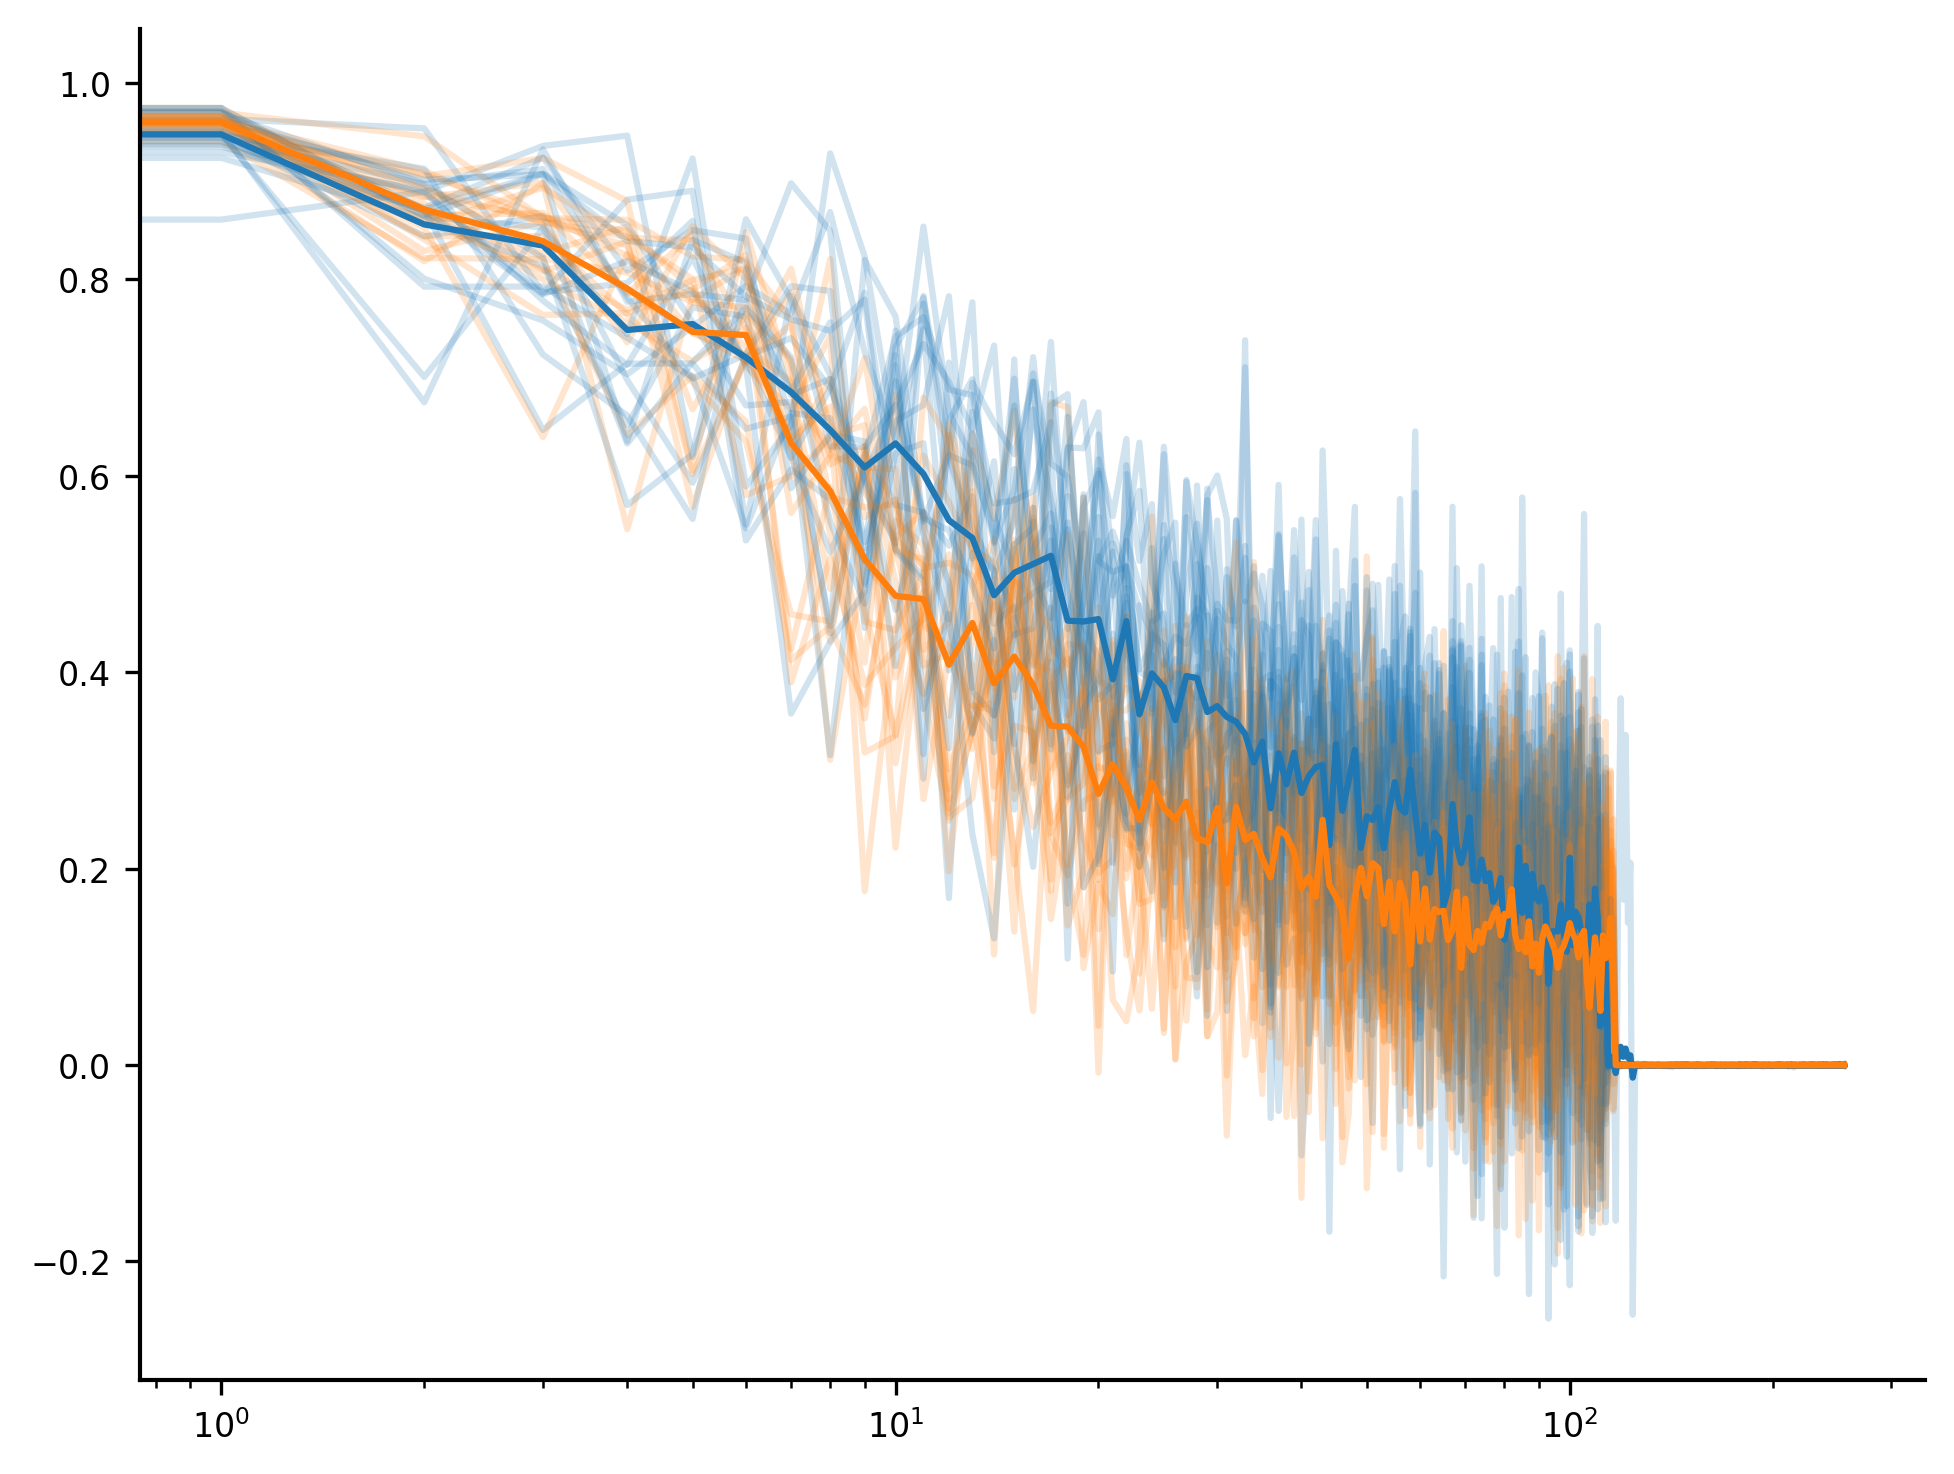

In [22]:
PRVs_contig = np.vstack([contig_shared[i]/contig_total[i] for i in range(20)])
PRVs_saltpep = np.vstack([saltpep_shared[i]/saltpep_total[i] for i in range(20)])
for i in range(20):
    plt.plot(PRVs_contig[i], color='C0', alpha=0.2)
    plt.plot(PRVs_saltpep[i], color='C1', alpha=0.2)
plt.plot(PRVs_contig.mean(0), color='C0')
plt.plot(PRVs_saltpep.mean(0), color='C1')
plt.xscale('log')
#plt.yscale('log')

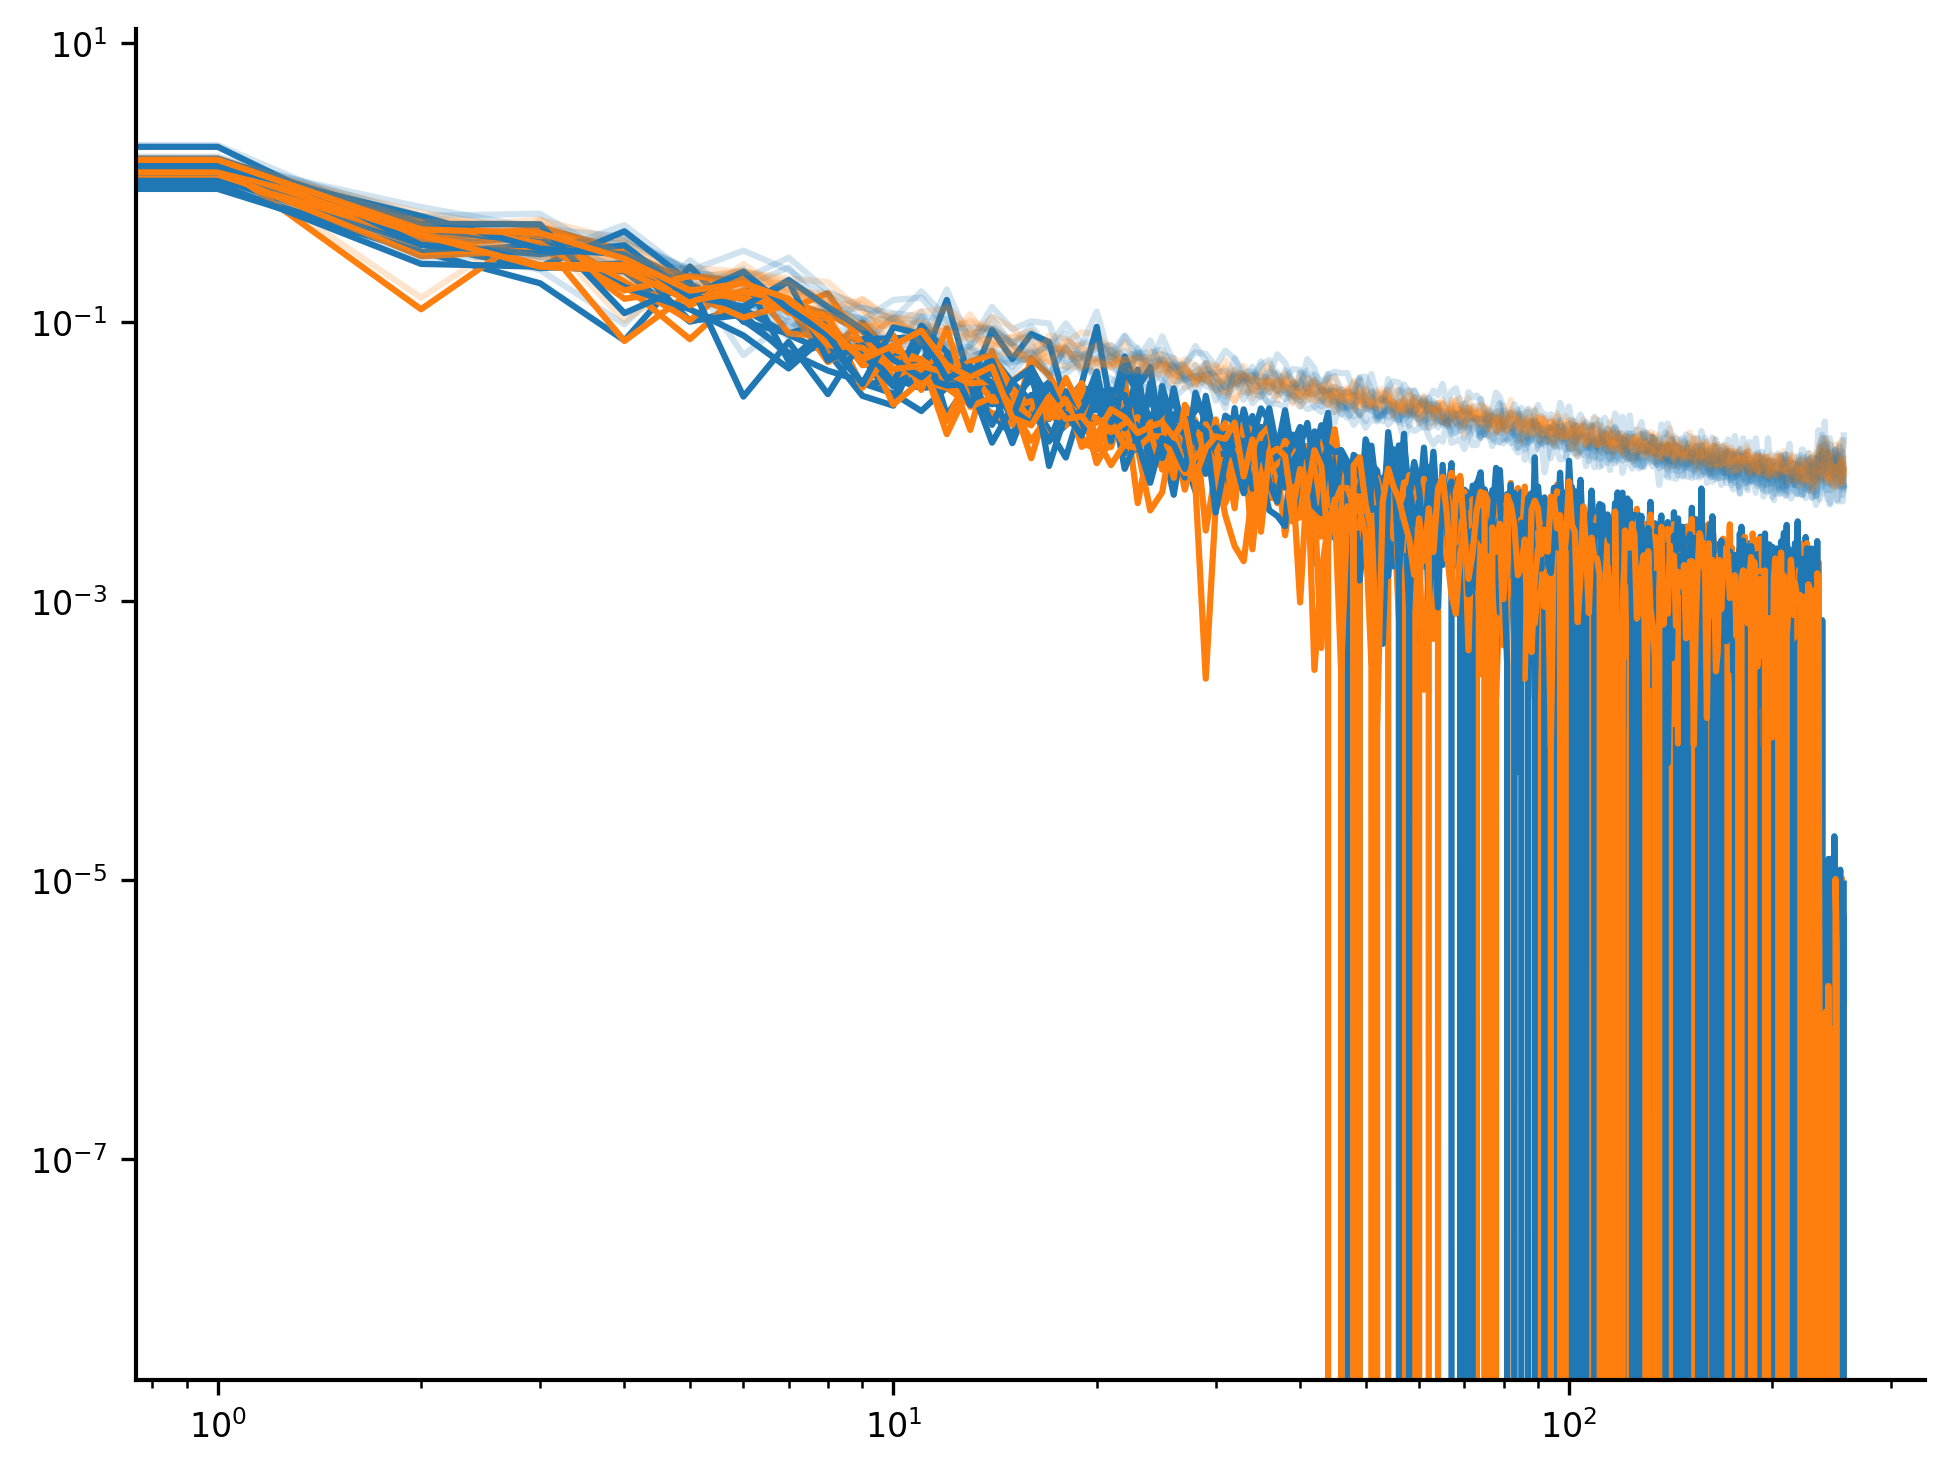

In [18]:
#PRVs_contig = np.vstack([contig_shared[i]/contig_total[i] for i in range(10)])
#PRVs_saltpep = np.vstack([saltpep_shared[i]/saltpep_total[i] for i in range(10)])
for i in range(10):
    plt.plot(contig_shared[i], color='C0', alpha=1)
    plt.plot(contig_total[i], color='C0', alpha=0.2)
    plt.plot(saltpep_shared[i], color='C1', alpha=1)
    plt.plot(saltpep_total[i], color='C1', alpha=0.2)
#plt.plot(PRVs_contig.mean(0), color='C0')
#plt.plot(PRVs_saltpep.mean(0), color='C1')
plt.xscale('log')
plt.yscale('log')

In [5]:
import numpy as np

# ------------------------------------------------------------
# One minimal function: fast, CV'd SVC with optional PCA + rank cap
# ------------------------------------------------------------
def svca_fast(
    X,                    # (N, T) neurons × time
    idxA, idxB,           # neuron indices for the two halves
    itime,                # 1D array of chosen time indices (subset to analyze)
    *,                    # keyword-only after this
    nblocks=10,           # interleaved blocks within the chosen itime for CV split
    pA=512, pB=512,       # optional PCA dims (None => no compression)
    r_max=256,            # cap number of cross-cov components evaluated (None => all)
    rng=None
):
    """
    Returns
    -------
    s_shared : (r,)  cross-validated shared variance per component (test)
    s_total  : (r,)  total variance per component (test)
    """
    if rng is None:
        rng = np.random.default_rng()

    # Ensure X is (N, T)
    assert X.ndim == 2
    N, T = X.shape

    # Select neurons
    XA = X[idxA]          # (nA, T)
    XB = X[idxB]          # (nB, T)

    # --- Time selection (subset) ---
    itime = np.asarray(itime, dtype=int)
    Tsub = itime.size
    if Tsub < nblocks:
        raise ValueError("nblocks exceeds number of selected time points")

    # Interleaved train/test within the *selected* time indices
    edges = np.linspace(0, Tsub, nblocks + 1, dtype=int)
    train_blocks = np.arange(0, nblocks, 2)
    test_blocks  = np.arange(1, nblocks, 2)
    sub_train = np.concatenate([np.arange(edges[b], edges[b+1]) for b in train_blocks])
    sub_test  = np.concatenate([np.arange(edges[b], edges[b+1]) for b in test_blocks])

    itrain = itime[sub_train]
    itest  = itime[sub_test]
    Ttr, Tte = itrain.size, itest.size
    if Ttr == 0 or Tte == 0:
        raise ValueError("Train/test split produced empty sets; try fewer blocks")

    # --- Center by train mean only (no leakage) ---
    muA = XA[:, itrain].mean(axis=1, keepdims=True)
    muB = XB[:, itrain].mean(axis=1, keepdims=True)
    XA_tr, XA_te = XA[:, itrain] - muA, XA[:, itest] - muA
    XB_tr, XB_te = XB[:, itrain] - muB, XB[:, itest] - muB

    # --- Optional PCA compression on train (apply to test) ---
    def pca_project(Xtr, Xte, p_keep):
        if (p_keep is None) or (p_keep >= min(Xtr.shape)):
            return Xtr, Xte, None  # no compression
        U, S, Vt = np.linalg.svd(Xtr, full_matrices=False)  # Xtr = U S V^T
        U = U[:, :p_keep].copy()
        return U.T @ Xtr, U.T @ Xte, U

    XA_tr_p, XA_te_p, UA = pca_project(XA_tr, XA_te, pA)
    XB_tr_p, XB_te_p, UB = pca_project(XB_tr, XB_te, pB)

    # --- Cross-cov SVD on train (compressed space) ---
    CAB_tr = (XA_tr_p @ XB_tr_p.T) / max(Ttr - 1, 1)
    U_p, s_tr, Vt_p = np.linalg.svd(CAB_tr, full_matrices=False)
    V_p = Vt_p.T
    rank = s_tr.size

    if r_max is not None:
        r = min(r_max, rank)
        U_p, V_p, s_tr = U_p[:, :r].copy(), V_p[:, :r].copy(), s_tr[:r].copy()
    else:
        r = rank

    # --- Vectorized test scoring (no big covariances) ---
    A = U_p.T @ XA_te_p          # (r, Tte)
    B = V_p.T @ XB_te_p          # (r, Tte)

    # Shared (CV) = diag(A @ B^T)/(Tte-1) = rowwise dot products
    s_shared = np.einsum('ik,ik->i', A, B) / max(Tte - 1, 1)

    # Total = 0.5*(||A||^2 + ||B||^2)/(Tte-1)
    AA = np.einsum('ik,ik->i', A, A)
    BB = np.einsum('ik,ik->i', B, B)
    s_total = 0.5 * (AA + BB) / max(Tte - 1, 1)

    return s_shared, s_total


# ============================================================
# Simple script (no extra functions): build two time partitions,
# loop over subsets, run svca_fast, save results.
# ============================================================

# ---- Your data here ----
# X should be (N, T). If you have (T, N), transpose it once:
# X = X_raw.T.copy()
kernel = np.ones(5)/5
X_filter = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis=1, arr=data['spks'])
#X_filter = np.convolve(data['spks'], filt, mode='same')
X = X_filter[:,::5]
assert X.ndim == 2
N, T = X.shape
print(f"N={N}, T={T}")

rng = np.random.default_rng(123)

# ---- Fix a single A/B neuron split for all runs (fair comparison) ----
permN = rng.permutation(N)
nA = N // 2
idxA = permN[:nA]
idxB = permN[nA:]

# ---- Partition settings ----
N_chunks = 10  # number of time subsets to compare
chunk_len = T // N_chunks
print(f"Using N_chunks={N_chunks}, chunk_len={chunk_len}")

# ---- Scheme 1: contiguous chunks, spaced evenly (disjoint) ----
contig_itimes = []
for k in range(N_chunks):
    start = k * chunk_len
    stop  = start + chunk_len if k < N_chunks - 1 else T  # last chunk takes the remainder
    contig_itimes.append(np.arange(start, stop, dtype=int))

# ---- Scheme 2: salt-and-pepper (random permutation partitioned evenly) ----
permT = rng.permutation(T)
saltpep_itimes = []
edges = np.linspace(0, T, N_chunks + 1, dtype=int)
for k in range(N_chunks):
    block = permT[edges[k]:edges[k+1]]
    # Optional: sort within each salt-pepper subset to preserve local order
    saltpep_itimes.append(np.sort(block))

N=24708, T=4717
Using N_chunks=10, chunk_len=471


In [6]:
# ---- Run SVC on each subset for both schemes ----
# Tunables for SVC:
nblocks = 10   # CV blocks within each subset
pA = 512       # PCA dims for A (None to disable)
pB = 512       # PCA dims for B (None to disable)
r_max = 256    # cap #components scored (None for all)

contig_results_shared = []
contig_results_total  = []
saltpep_results_shared = []
saltpep_results_total  = []

for k in range(N_chunks):
    # Contiguous
    sS, sT = svca_fast(
        X, idxA, idxB, contig_itimes[k],
        nblocks=nblocks, pA=pA, pB=pB, r_max=r_max, rng=rng
    )
    contig_results_shared.append(sS)
    contig_results_total.append(sT)

    # Salt-and-pepper
    sS, sT = svca_fast(
        X, idxA, idxB, saltpep_itimes[k],
        nblocks=nblocks, pA=pA, pB=pB, r_max=r_max, rng=rng
    )
    saltpep_results_shared.append(sS)
    saltpep_results_total.append(sT)

    print(f"Chunk {k+1}/{N_chunks} done:"
          f" contig r={len(contig_results_shared[-1])},"
          f" saltpep r={len(saltpep_results_shared[-1])}")

# ---- Save results ----
# Store as object arrays to accommodate any r variations safely.
# out_path = "svc_chunk_compare.npz"
# np.savez(
#     out_path,
#     idxA=idxA, idxB=idxB,
#     contig_itimes=contig_itimes, saltpep_itimes=saltpep_itimes,
#     contig_shared=np.array(contig_results_shared, dtype=object),
#     contig_total=np.array(contig_results_total, dtype=object),
#     saltpep_shared=np.array(saltpep_results_shared, dtype=object),
#     saltpep_total=np.array(saltpep_results_total, dtype=object),
#     meta=np.array(dict(nblocks=nblocks, pA=pA, pB=pB, r_max=r_max, N_chunks=N_chunks), dtype=object),
# )
# print(f"Saved results to {out_path}")

KeyboardInterrupt: 

In [3]:
import numpy as np

# ---------------------------------------------------------------------
#  Fast, minimal SVCA-style analysis with PCA compression + vectorized scoring
# ---------------------------------------------------------------------
# X: array (N, T) = neurons × time
# If you have (T, N), do:  X = X_raw.T
# Tunables:
#   pA, pB    : #PCs to keep for A/B (None => no compression). Try 256–512.
#   r_max     : truncate #cross-cov components to score (None => all)
#   nblocks   : #interleaved time blocks (use more if long-range correlations)
# ---------------------------------------------------------------------

# ---- user inputs / tunables ----
rng = np.random.default_rng(0)
kernel = np.ones(5)/5
X_filter = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis=1, arr=data['spks'])
#X_filter = np.convolve(data['spks'], filt, mode='same')
X = X_filter[:,::5]
assert X.ndim == 2
N, T = X.shape
pA, pB = 512, 512           # set to None to disable PCA compression
r_max  = 256                # cap the #components scored after SVD (None => all)
nblocks = 10                # time blocks for train/test split

print(f"N={N}, T={T} | pA={pA}, pB={pB}, r_max={r_max}, nblocks={nblocks}")

# ---- 1) Splits: neurons (A/B) and time (train/test) ----
perm = rng.permutation(N)
nA = N // 2
idxA = perm[:nA]           # A neurons
idxB = perm[nA:]           # B neurons

edges = np.linspace(0, T, nblocks+1, dtype=int)
train_blocks = np.arange(0, nblocks, 2)  # even blocks -> train
test_blocks  = np.arange(1, nblocks, 2)  # odd blocks  -> test
itrain = np.concatenate([np.arange(edges[b], edges[b+1]) for b in train_blocks])
itest  = np.concatenate([np.arange(edges[b], edges[b+1]) for b in test_blocks])
Ttr, Tte = len(itrain), len(itest)
print(f"A={len(idxA)}, B={len(idxB)}, T_train={Ttr}, T_test={Tte}")

# ---- 2) Center by *train* mean only (no leakage) ----
XA = X[idxA]                      # (nA, T)
XB = X[idxB]                      # (nB, T)
muA = XA[:, itrain].mean(axis=1, keepdims=True)
muB = XB[:, itrain].mean(axis=1, keepdims=True)
XA_tr, XA_te = XA[:, itrain] - muA, XA[:, itest] - muA
XB_tr, XB_te = XB[:, itrain] - muB, XB[:, itest] - muB

# ---- 3) Optional PCA compression (fit on train, apply to train & test) ----
def pca_compress(Xtr, Xte, p_keep=None):
    # SVD of train data matrix (neurons × time): Xtr = U S V^T
    # Columns of U are neuron-space PCs. Project by U^T.
    if (p_keep is None) or (p_keep >= min(Xtr.shape)):
        # no compression, return identity-projected data
        U = None
        return Xtr, Xte, U
    U, S, Vt = np.linalg.svd(Xtr, full_matrices=False)  # U:(n, r), Vt:(r, Ttr)
    U = U[:, :p_keep].copy()                             # neuron PCs kept
    Xtr_p = U.T @ Xtr                                   # (p_keep, Ttr)
    Xte_p  = U.T @ Xte                                  # (p_keep, Tte)
    return Xtr_p, Xte_p, U

XA_tr_p, XA_te_p, UA = pca_compress(XA_tr, XA_te, pA)
XB_tr_p, XB_te_p, UB = pca_compress(XB_tr, XB_te, pB)

# Sizes after compression
nA_eff = XA_tr_p.shape[0]
nB_eff = XB_tr_p.shape[0]
print(f"Effective dims: A={nA_eff}, B={nB_eff}")

# ---- 4) SVD of train cross-cov in compressed space ----
CAB_tr = (XA_tr_p @ XB_tr_p.T) / max(Ttr - 1, 1)   # (nA_eff × nB_eff)
U_p, s_tr, Vt_p = np.linalg.svd(CAB_tr, full_matrices=False)  # U_p:(nA_eff, r), Vt_p:(r, nB_eff)
V_p = Vt_p.T
rank = s_tr.size

# optional rank truncation for scoring
if r_max is not None:
    r = min(r_max, rank)
    U_p, s_tr, V_p = U_p[:, :r].copy(), s_tr[:r].copy(), V_p[:, :r].copy()
else:
    r = rank
print(f"Cross-cov rank used: r={r}")

# If you want neuron-space singular vectors, map back: U = UA @ U_p (if UA not None), etc.
# For fast scoring we can stay in compressed coordinates.

# ---- 5) Vectorized cross-validated scoring on test (NO big covariances) ----
# Project test data into the cross-cov directions:
#   A = U_p^T X_A^test   (r × Tte)
#   B = V_p^T X_B^test   (r × Tte)
A = U_p.T @ XA_te_p
B = V_p.T @ XB_te_p

# shared per-component: diag(A @ B^T) / (Tte - 1)
s_shared = np.einsum('ik,ik->i', A, B) / max(Tte - 1, 1)

# total per-component: 0.5*(||A||^2 + ||B||^2) / (Tte - 1)
AA = np.einsum('ik,ik->i', A, A)
BB = np.einsum('ik,ik->i', B, B)
s_total = 0.5 * (AA + BB) / max(Tte - 1, 1)

eps = 1e-12
f_shared = np.clip(s_shared / (s_total + eps), 0.0, 1.0)
print("Top 10 f_shared:", np.round(f_shared[:10], 3), "| mean:", f_shared.mean().round(3))

# ---- 6) Simple null (time reversal in B on test) ----
B_mis = V_p.T @ XB_te_p[:, ::-1]
s_shared_null = np.einsum('ik,ik->i', A, B_mis) / max(Tte - 1, 1)
f_shared_null = np.clip(s_shared_null / (s_total + eps), 0.0, 1.0)
thr = np.percentile(f_shared_null, 95)
reliable_dim = int((f_shared > thr).sum())
print("Null 95th percentile:", round(thr, 3))
print("Reliable dimensionality (count above null):", reliable_dim)

N=24708, T=4717 | pA=512, pB=512, r_max=256, nblocks=10
A=12354, B=12354, T_train=2358, T_test=2359
Effective dims: A=512, B=512
Cross-cov rank used: r=256
Top 10 f_shared: [0.985 0.963 0.895 0.916 0.855 0.884 0.873 0.771 0.762 0.703] | mean: 0.222
Null 95th percentile: 0.052
Reliable dimensionality (count above null): 254


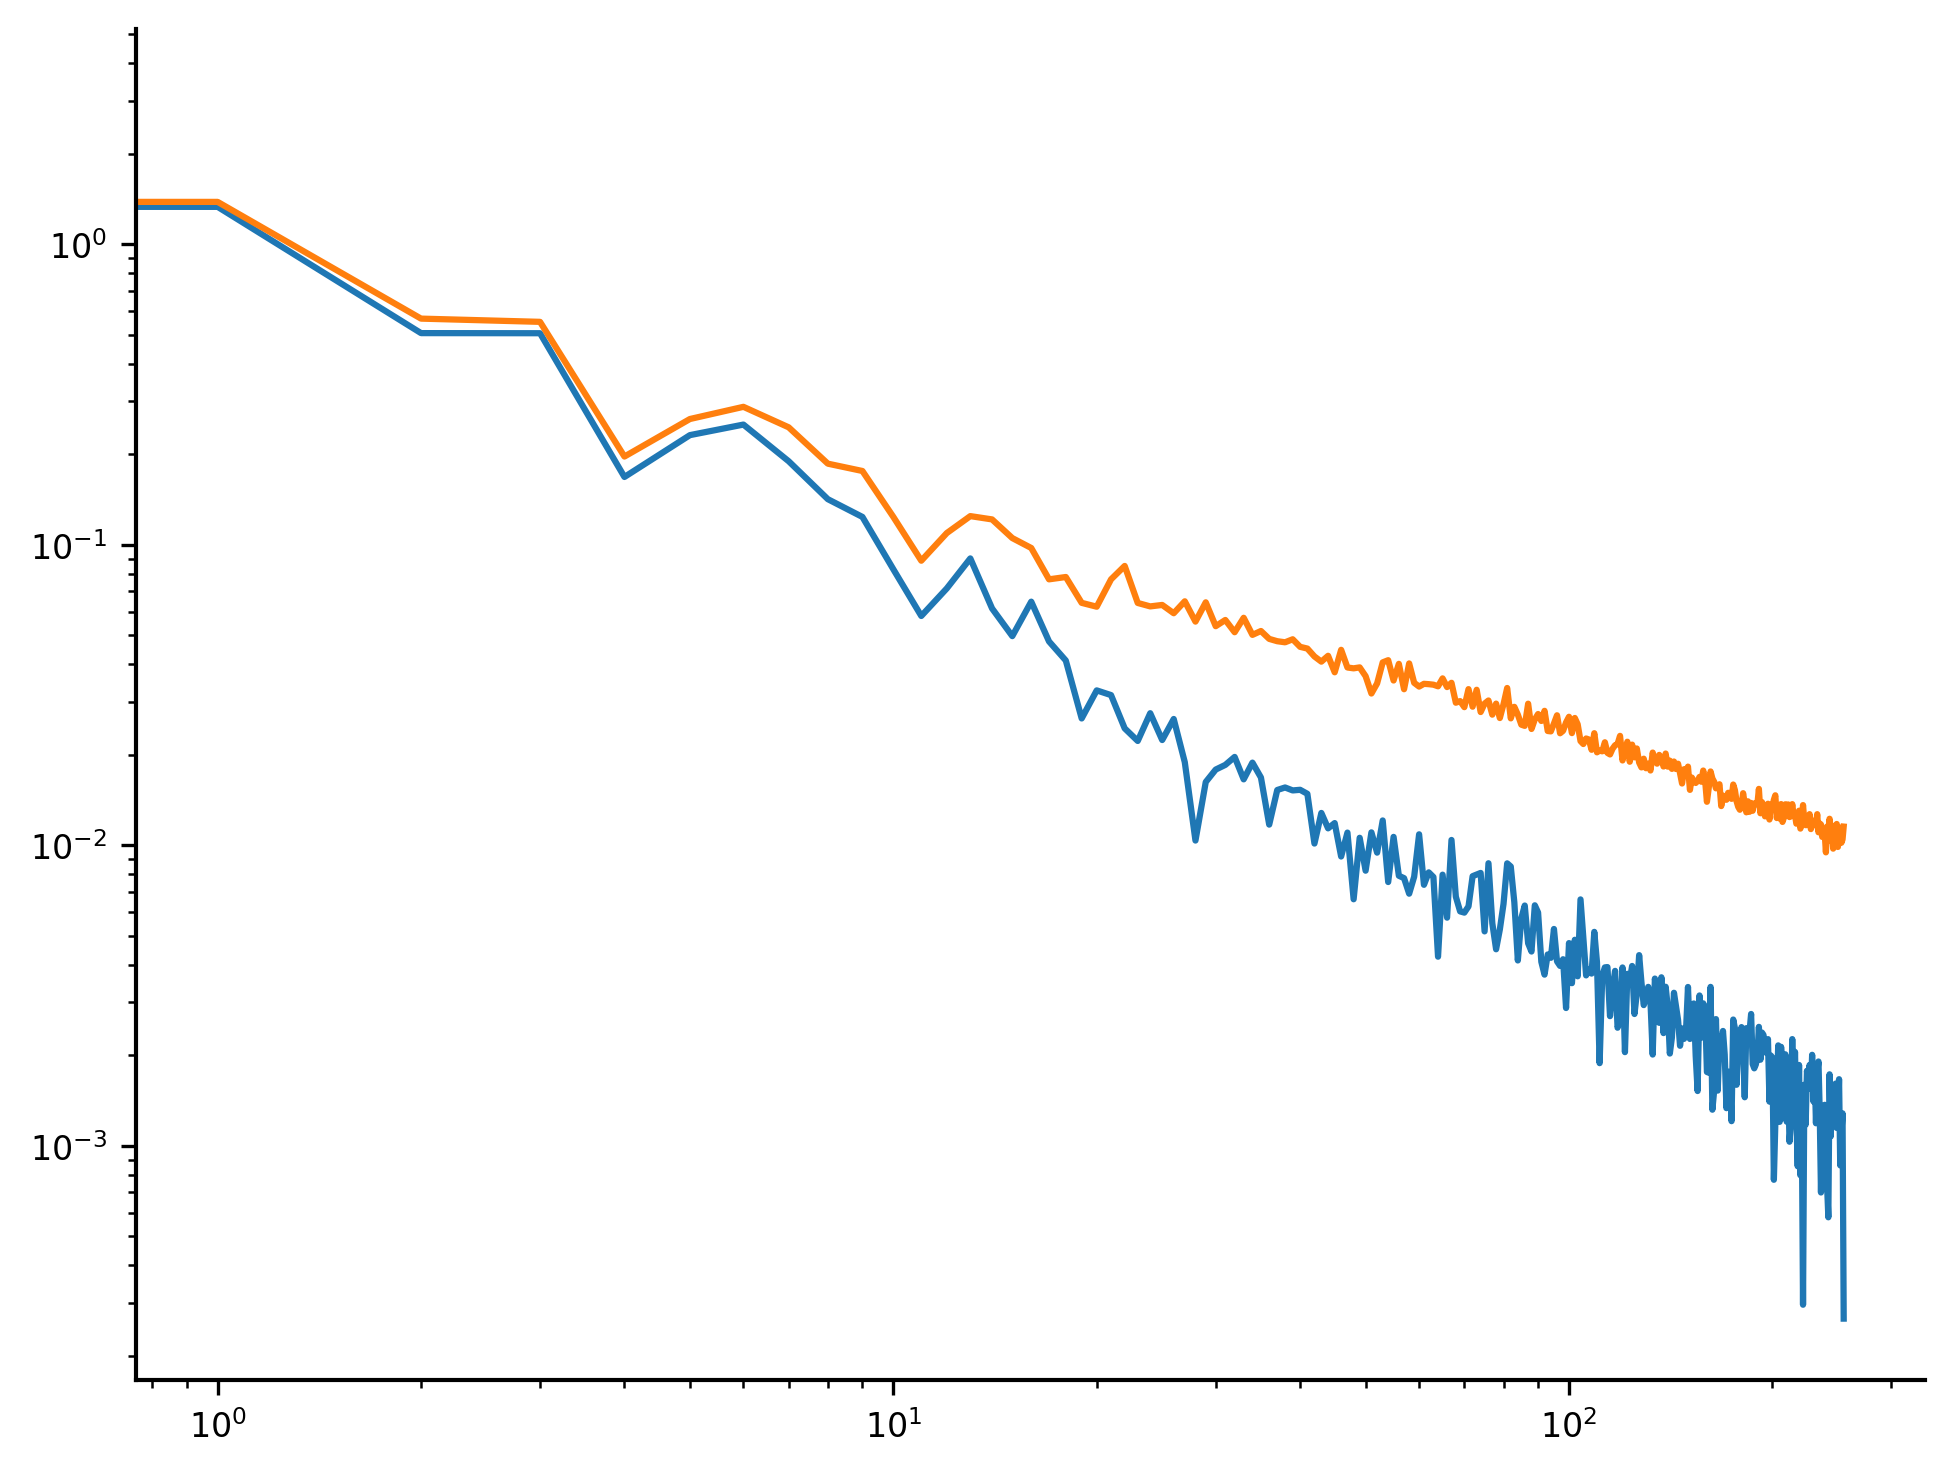

In [4]:
#plt.plot(f_shared)
plt.plot(s_shared)
plt.plot(s_total)
plt.xscale('log')
plt.yscale('log')

In [ ]:
import numpy as np

# ---------------------------------------------------------------------
#  Minimal, transparent SVCA-style analysis
# ---------------------------------------------------------------------
# X: array of shape (N, T) = neurons × time
# (If your data is (T, N), transpose once: X = X_raw.T)
# ---------------------------------------------------------------------

# ---- 0. basic setup ----
rng = np.random.default_rng(0)
X = data['spks'][:,::5]
assert X.ndim == 2
N, T = X.shape
print(f"N={N}, T={T}")

# ---- 1. splits ----
# neuron split (A/B)
perm = rng.permutation(N)
nA = N // 2
ntrain_neurons = perm[:nA]   # set A
ntest_neurons  = perm[nA:]   # set B

# time split (interleaved blocks)
nblocks = 10
edges = np.linspace(0, T, nblocks+1, dtype=int)
train_blocks = np.arange(0, nblocks, 2)  # even blocks -> train
test_blocks  = np.arange(1, nblocks, 2)  # odd blocks  -> test
itrain = np.concatenate([np.arange(edges[b], edges[b+1]) for b in train_blocks])
itest  = np.concatenate([np.arange(edges[b], edges[b+1]) for b in test_blocks])

print(f"A={len(ntrain_neurons)}, B={len(ntest_neurons)}, "
      f"T_train={len(itrain)}, T_test={len(itest)}")

# ---- 2. center by train mean ----
def center_train_only(X, itrain, itest):
    mu = X[:, itrain].mean(axis=1, keepdims=True)
    Xc = X - mu
    return Xc[:, itrain], Xc[:, itest]

XA = X[ntrain_neurons]
XB = X[ntest_neurons]
XA_tr, XA_te = center_train_only(XA, itrain, itest)
XB_tr, XB_te = center_train_only(XB, itrain, itest)

# ---- 3. train cross-covariance SVD ----
Ttr = XA_tr.shape[1]
CAB_tr = (XA_tr @ XB_tr.T) / max(Ttr - 1, 1)
U, s_train, Vt = np.linalg.svd(CAB_tr, full_matrices=False)
V = Vt.T
rank = s_train.size
print("rank =", rank)

# ---- 4. cross-validated shared variance on test ----
Tte = XA_te.shape[1]
CAB_te = (XA_te @ XB_te.T) / max(Tte - 1, 1)
s_shared = np.array([U[:,k].T @ CAB_te @ V[:,k] for k in range(rank)])

# ---- 5. total variance on test ----
CAA_te = (XA_te @ XA_te.T) / max(Tte - 1, 1)
CBB_te = (XB_te @ XB_te.T) / max(Tte - 1, 1)
s_total = np.array([
    0.5 * (U[:,k].T @ CAA_te @ U[:,k] + V[:,k].T @ CBB_te @ V[:,k])
    for k in range(rank)
])

# ---- 6. fraction shared ----
eps = 1e-12
f_shared = np.clip(s_shared / (s_total + eps), 0.0, 1.0)
print("Top 10 f_shared:", np.round(f_shared[:10], 3))
print("Mean f_shared:", f_shared.mean().round(3))

# ---- 7. simple null (time-reversed B test data) ----
XB_te_mis = XB_te[:, ::-1]
CAB_te_null = (XA_te @ XB_te_mis.T) / max(Tte - 1, 1)
s_shared_null = np.array([U[:,k].T @ CAB_te_null @ V[:,k] for k in range(rank)])
f_shared_null = np.clip(s_shared_null / (s_total + eps), 0.0, 1.0)
thr = np.percentile(f_shared_null, 95)
reliable_dim = int((f_shared > thr).sum())
print("Null 95th percentile:", round(thr, 3))
print("Reliable dimensionality (count above null):", reliable_dim)

In [ ]:
max_nneur = data['spks'].shape[0]

In [ ]:
neurons = data['spks'].T
centers = np.vstack([data['xpos'], data['ypos']])

In [ ]:
x = neurons[:,:100]
x = x - x.mean(0)[None, :]
acov = np.vstack([np.mean(np.roll(x, lag, axis=0) * x, axis=0) for lag in range(500)])

In [ ]:
y = data['run'].copy()
y = y - y.mean(0)
acov_run = np.array([np.mean(np.roll(y,lag) * y) for lag in range(500)])

In [ ]:
acov = np.vstack(acov)

In [ ]:
plt.plot(acov[:,0])
plt.plot(acov[:,1])
plt.plot(acov[:,2])
plt.plot(acov[:,3])
plt.plot(acov_run)

In [ ]:
plt.plot(y[:500])

In [ ]:
plt.plot(neurons[:100,0])
plt.plot(neurons[:100,1])
plt.plot(neurons[:100,2])

To reduce the computational complexity for these examples, let's randomly sample some number of neurons from this large dataset.

In [ ]:
#max_nneur = 2**16
# PARAMETERS
# Note: these analyses can take quite some time to run for large neuron numbers
# Reduce nneurs, nsamplings, nsvc, and/or nsvc_predict for smaller, efficient tests
checkerboard = 250              # size of lateral checkerboard pattern to split neural sets, in um
nsamplings = 3                  # number of samplings to perform
lag = -1                        # lag between motion and neural data, in frames
#interleave = int(72*fhz)        # length of chunks that are randomly assigned to training or testing, in frames
interleave = 10
nsvc = 512                      # number of SVCs to find
nsvc_predict = 64               # number of SVCs to predict from behavior
lams = [0.01, 0.1]              # regularization parameters for reduced rank regression of neural SVCs
ranks = np.unique(np.round(     # ranks to test in reduced rank regression of neural SVCs
    2 ** np.arange(2,8))
                 ).astype(int)

MLPregressor = False             # whether or not to fit MLP nonlinear model
prePCA = False                   # whether or not to perform PCA before running SVCA
                                 #         (saves memory for large neuron number, but takes longer)

In [ ]:
nneurs = [max_nneur]
cov_neurs = np.zeros((len(nneurs), nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nneurs), nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nneurs), nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

motion = np.zeros((neurons.shape[0], 10))
for n in range(len(nneurs)):
    print(nneurs[n], 'NEURONS')
    (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
    ntrain, ntest, itrain, itest, pca) = \
        predict_from_behavior(neurons, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                              lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                              prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

    cov_neurs[n,:] = cov_neur
    var_neurs[n,:] = var_neur
    cov_res_behs[n,:] = cov_res_beh

    ex_u.append(u)
    ex_v.append(v)
    ex_ntrain.append(ntrain)
    ex_ntest.append(ntest)
    ex_itrain.append(itrain)
    ex_itest.append(itest)

In [ ]:
cov_neurs

In [ ]:
cov = np.nanmean(cov_neurs, axis=-1)
var = np.nanmean(var_neurs, axis=-1)

fig, ax = plt.subplots(2, 2)
for i in range(1):
    for j in range(2):
        ax[0,j].plot(cov[i]/nneurs[i], color='C{}'.format(i), linestyle='--', alpha=0.2)
        ax[0,j].plot(var[i]/nneurs[i], color='C{}'.format(i))
        ax[1,j].plot(cov[i], color='C{}'.format(i), linestyle='--', alpha=0.2)
        ax[1,j].plot(var[i], color='C{}'.format(i))
        ax[0,j].set_xscale('log')
        ax[0,j].set_yscale('log')
        ax[1,j].set_xscale('log')
        ax[1,j].set_yscale('log')

In [ ]:
# PLOT % RELIABLE VARIANCE VS. SVC # FOR EACH NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

# Plot shuffed data
#relvar_shuff = np.nanmean(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#relvar_shuff_std = np.nanstd(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#l,=plt.plot(np.arange(len(relvar_shuff))+1, relvar_shuff*100, color='r')
#plt.fill_between(np.arange(len(relvar_shuff))+1, (relvar_shuff - relvar_shuff_std)*100,
#                 (relvar_shuff + relvar_shuff_std)*100, color='r', alpha=0.3)

# Plot data
for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,:]/var_neurs[n,:],axis=-1)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n])
    ls.append(l)

plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.ylim([-10, 100])
plt.xscale('log');

In [ ]:
nchunks = [7, 10, 20]
max_nchunks = np.amax(nchunks)
max_nchunks = 5
cov_neurs = np.zeros((len(nchunks), 2, max_nchunks, nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nchunks), 2, max_nchunks, nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nchunks), 2, max_nchunks, nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

neurons = data['spks'].T[::5]
centers = np.vstack([data['xpos'], data['ypos']])

n = 0
interleave = 10
T = neurons.shape[0]
for i_chunk, chunks in enumerate(nchunks):
    rand_partitions = np.random.choice(list(range(chunks)), size=max_nchunks, replace=False)
    for i_partition, partition in enumerate(rand_partitions):
        print(nneurs[n], 'NEURONS')
        i1 = np.array_split(np.arange(T), chunks)[partition]
        i2 = np.array_split(np.random.permutation(np.arange(T)), chunks)[partition]
        X1 = neurons[i1]
        X2 = neurons[i2]
        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(X1, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[i_chunk,0,i_partition,:] = cov_neur
        var_neurs[i_chunk,0,i_partition,:] = var_neur
        cov_res_behs[i_chunk,0,i_partition,:] = cov_res_beh

        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(X2, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[i_chunk,1,i_partition,:] = cov_neur
        var_neurs[i_chunk,1,i_partition,:] = var_neur
        cov_res_behs[i_chunk,1,i_partition,:] = cov_res_beh

In [ ]:
neurons.shape

In [ ]:
data['tneural'][-1]- data['tneural'][0]

In [ ]:
rng = np.random.default_rng(seed=138)
idx = rng.permutation(expt.T_all.shape[1])[:max_nneur]

neurons = expt.T_all[:,idx]
centers = expt.centers[:,idx]
expt.T_all = [] # save memory
neurons = neurons.astype('single')

In [ ]:
# z-scored neural data
neurons = zscore(neurons)
print(file, "contains", neurons.shape[1], "neurons and", neurons.shape[0], "timepoints")

# z-scored facial videography behavior data
motion = zscore(expt.motion.astype('single')) * 10
print(file, "contains", motion.shape[1], "behavior PCs and", motion.shape[0], "timepoints")

Y = expt.Y # MIP of recording
fhz = expt.fhz # volume rate
t = expt.t # timestamps (in seconds)
treadmill_velocity = expt.velocity_events

del expt

In [ ]:
# PLOT MAXIMUM INTENSITY PROJECTIONS OF FOV

plot_MIPs(Y)

In [ ]:
# PLOT EXAMPLE NEURAL AND BEHAVIORAL DYNAMICS

min_start = 3 # minutes
min_stop = 6 # minutes

t_idx = np.arange(int(fhz * min_start * 60),
                  int(fhz * min_stop * 60))

neurons_example = zscore(neurons[t_idx,:])
motion_example = zscore(motion[t_idx, :3])

model = Rastermap(n_PCs=32, n_clusters=8).fit(neurons_example.T)

In [ ]:
plot_neurons_behavior(neurons_example[:,model.isort], motion_example,
                      treadmill_velocity[t_idx], t[t_idx]);

## SVCA on varying neuron numbers

In [ ]:
# PARAMETERS
# Note: these analyses can take quite some time to run for large neuron numbers
# Reduce nneurs, nsamplings, nsvc, and/or nsvc_predict for smaller, efficient tests
nneurs = 2 ** np.arange(8,16)   # numbers of neurons to sample
checkerboard = 250              # size of lateral checkerboard pattern to split neural sets, in um
nsamplings = 3                  # number of samplings to perform
lag = -1                        # lag between motion and neural data, in frames
interleave = int(72*fhz)        # length of chunks that are randomly assigned to training or testing, in frames
#interleave = 10
nsvc = 512                      # number of SVCs to find
nsvc_predict = 64               # number of SVCs to predict from behavior
lams = [0.01, 0.1]              # regularization parameters for reduced rank regression of neural SVCs
ranks = np.unique(np.round(     # ranks to test in reduced rank regression of neural SVCs
    2 ** np.arange(2,8))
                 ).astype(int)

MLPregressor = False             # whether or not to fit MLP nonlinear model
prePCA = False                   # whether or not to perform PCA before running SVCA
                                 #         (saves memory for large neuron number, but takes longer)

In [ ]:
nneurs = [max_nneur]
cov_neurs = np.zeros((len(nneurs), nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nneurs), nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nneurs), nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []


for n in range(len(nneurs)):
    print(nneurs[n], 'NEURONS')
    (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
    ntrain, ntest, itrain, itest, pca) = \
        predict_from_behavior(neurons, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                              lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                              prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

    cov_neurs[n,:] = cov_neur
    var_neurs[n,:] = var_neur
    cov_res_behs[n,:] = cov_res_beh

    ex_u.append(u)
    ex_v.append(v)
    ex_ntrain.append(ntrain)
    ex_ntest.append(ntest)
    ex_itrain.append(itrain)
    ex_itest.append(itest)

In [ ]:
latents = neurons[:,ntrain].dot(ex_u[0])

In [ ]:
latents.shape

In [ ]:
U, S, VT = np.linalg.svd(latents)
plt.plot(S[:latents.shape[1]], '.')
plt.plot(np.var(latents, axis=0))
plt.xscale('log')
plt.yscale('log')

In [ ]:
neurons.shape

In [ ]:
T = neurons.shape[0]
#ntimes = [T//32, T//16, T//8, T//4, T//2, T]
ntimes = [T//20, T]
cov_neurs = np.zeros((len(nneurs), len(ntimes), nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nneurs), len(ntimes), nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nneurs), len(ntimes), nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []


for n in range(len(nneurs)):
    for t in range(len(ntimes)):
        print(nneurs[n], 'NEURONS')
        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(neurons[:ntimes[t]], nneurs[n], centers, motion[:ntimes[t]], ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[n,:] = cov_neur
        var_neurs[n,:] = var_neur
        cov_res_behs[n,:] = cov_res_beh

        ex_u.append(u)
        ex_v.append(v)
        ex_ntrain.append(ntrain)
        ex_ntest.append(ntest)
        ex_itrain.append(itrain)
        ex_itest.append(itest)

In [ ]:
neurons.shape

In [ ]:
cov = np.nanmean(cov_neurs, axis=-1)
var = np.nanmean(var_neurs, axis=-1)

In [ ]:
fig, ax = plt.subplots(2, 2)
for i in range(8):
    for j in range(2):
        ax[0,j].plot(cov[i,j]/nneurs[i], color='C{}'.format(i), linestyle='--', alpha=0.2)
        ax[0,j].plot(var[i,j]/nneurs[i], color='C{}'.format(i))
        ax[1,j].plot(cov[i,j], color='C{}'.format(i), linestyle='--', alpha=0.2)
        ax[1,j].plot(var[i,j], color='C{}'.format(i))
        ax[0,j].set_xscale('log')
        ax[0,j].set_yscale('log')
        ax[1,j].set_xscale('log')
        ax[1,j].set_yscale('log')

In [ ]:
fig, ax = plt.subplots(2, 4)
for i in range(8):
    for j in range(4):
        ax[0,j].plot(cov[i,j]/nneurs[i], color='C{}'.format(i), linestyle='--', alpha=0.2)
        ax[0,j].plot(var[i,j]/nneurs[i], color='C{}'.format(i))
        ax[1,j].plot(cov[i,j], color='C{}'.format(i), linestyle='--', alpha=0.2)
        ax[1,j].plot(var[i,j], color='C{}'.format(i))
        ax[0,j].set_xscale('log')
        ax[0,j].set_yscale('log')
        ax[1,j].set_xscale('log')
        ax[1,j].set_yscale('log')

In [ ]:
cov_neurs.shape

### Shuffling tests

In [ ]:
# Compute shuffled SVCs

nsamplings_shuff = 5 # ideally we'd want more to get a good sense
                     # of the distribution of shuffled coefficients

cov_neurs_shuff = np.zeros((nsvc, nsamplings_shuff))+np.nan
var_neurs_shuff = np.zeros((nsvc, nsamplings_shuff))+np.nan
cov_res_behs_shuff = np.zeros((nsvc_predict, len(ranks), len(lams), nsamplings_shuff))+np.nan

ex_u_shuff = []
ex_v_shuff = []
ex_ntrain_shuff = []
ex_ntest_shuff = []
ex_itrain_shuff = []
ex_itest_shuff = []

# Run predict_from_behavior many times with 1 sampling each,
# so that we save the example u, v, etc. every time we run SVCA
for i in range(nsamplings_shuff):
    print("SAMPLING", i+1, "OUT OF", nsamplings_shuff)
    (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
    ntrain, ntest, itrain, itest, pca) = \
        predict_from_behavior(neurons, nneurs[-1], centers, motion, ranks, nsamplings=1, lag=lag,
                              lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                              prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave, shuffle=True)
    
    cov_neurs_shuff[:,i] = cov_neur[:,0]
    var_neurs_shuff[:,i] = var_neur[:,0]
    cov_res_behs_shuff[:,i] = cov_res_beh[:,0]
    
    ex_u_shuff.append(u)
    ex_v_shuff.append(v)
    ex_ntrain_shuff.append(ntrain)
    ex_ntest_shuff.append(ntest)
    ex_itrain_shuff.append(itrain)
    ex_itest_shuff.append(itest)

### The reliable dimensionality scales in an unbounded fashion with the number of randomly sampled neurons

In [ ]:
# PLOT % RELIABLE VARIANCE VS. SVC # FOR EACH NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

# Plot shuffed data
#relvar_shuff = np.nanmean(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#relvar_shuff_std = np.nanstd(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#l,=plt.plot(np.arange(len(relvar_shuff))+1, relvar_shuff*100, color='r')
#plt.fill_between(np.arange(len(relvar_shuff))+1, (relvar_shuff - relvar_shuff_std)*100,
#                 (relvar_shuff + relvar_shuff_std)*100, color='r', alpha=0.3)

# Plot data
for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,:]/var_neurs[n,:],axis=-1)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n])
    ls.append(l)

plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.ylim([-10, 100])
plt.xscale('log');

In [ ]:
# PLOT % RELIABLE VARIANCE VS. SVC # FOR EACH NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

# Plot shuffed data
#relvar_shuff = np.nanmean(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#relvar_shuff_std = np.nanstd(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#l,=plt.plot(np.arange(len(relvar_shuff))+1, relvar_shuff*100, color='r')
#plt.fill_between(np.arange(len(relvar_shuff))+1, (relvar_shuff - relvar_shuff_std)*100,
#                 (relvar_shuff + relvar_shuff_std)*100, color='r', alpha=0.3)

# Plot data
for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,:]/var_neurs[n,:],axis=-1)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n])
    ls.append(l)

plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.ylim([-10, 100])
plt.xscale('log');

In [ ]:
cov_neurs = np.zeros((len(nneurs), nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nneurs), nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nneurs), nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

interleaves = [10, 40, 80, 160, 320, 640]

n = 7
for i_int, intervleave in enumerate(interleaves):
    print(nneurs[n], 'NEURONS')
    (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
    ntrain, ntest, itrain, itest, pca) = \
        predict_from_behavior(neurons, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                              lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                              prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)
    
    cov_neurs[i_int,:] = cov_neur
    var_neurs[i_int,:] = var_neur
    cov_res_behs[i_int,:] = cov_res_beh
    
    ex_u.append(u)
    ex_v.append(v)
    ex_ntrain.append(ntrain)
    ex_ntest.append(ntest)
    ex_itrain.append(itrain)
    ex_itest.append(itest)

In [ ]:
plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(interleaves)))
ls = []
for i in range(len(interleaves)):
    relvar = np.nanmean(cov_neurs[i,:]/var_neurs[i,:],axis=-1)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[i])
    ls.append(l)
plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(interleaves), title='interleave samples')
plt.ylim([-10, 100])
plt.xscale('log');

In [ ]:
nchunks = [2, 4, 8, 16, 32, 64]
cov_neurs = np.zeros((len(nchunks), 2, nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nchunks), 2, nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nchunks), 2, nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

n = 5
interleave = 100
T = neurons.shape[0]
for i_chunk, chunks in enumerate(nchunks):
    print(nneurs[n], 'NEURONS')
    T_checkerboard = T//chunks #samples, not seconds
    T_indices = np.array(range(0, T // T_checkerboard * T_checkerboard))
    T_indices = T_indices.reshape((-1, T_checkerboard))
    i1 = T_indices[0::2].flatten()
    i2 = T_indices[1::2].flatten()
    X1 = neurons[i1]
    X2 = neurons[i2]
    (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
    ntrain, ntest, itrain, itest, pca) = \
        predict_from_behavior(X1, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                              lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                              prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)
    
    cov_neurs[i_chunk,0,:] = cov_neur
    var_neurs[i_chunk,0,:] = var_neur
    cov_res_behs[i_chunk,0,:] = cov_res_beh
    
    (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
    ntrain, ntest, itrain, itest, pca) = \
        predict_from_behavior(X2, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                              lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                              prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)
    
    cov_neurs[i_chunk,1,:] = cov_neur
    var_neurs[i_chunk,1,:] = var_neur
    cov_res_behs[i_chunk,1,:] = cov_res_beh
    
    ex_u.append(u)
    ex_v.append(v)
    ex_ntrain.append(ntrain)
    ex_ntest.append(ntest)
    ex_itrain.append(itrain)
    ex_itest.append(itest)

In [ ]:
plt.figure(figsize=(4,2))
#colors = plt.cm.viridis(np.linspace(0,1,len(interleaves)))
colors = ['C{}'.format(i_col) for i_col in range(6)]
ls = []
for i in range(len(nchunks)):
    for i_12 in range(2):
        relvar = np.nanmean(cov_neurs[i,i_12,:]/var_neurs[i,i_12,:],axis=-1)
        l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[i])
        if i_12 == 0:
            ls.append(l)
plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(nchunks), title='chunk size')
plt.ylim([-10, 100])
plt.xscale('log');

In [ ]:
nneurs = 2**np.arange(9, 17)

In [ ]:
nneurs

In [ ]:
nchunks = [7, 10, 20]
max_nchunks = np.amax(nchunks)
max_nchunks = 5
cov_neurs = np.zeros((len(nchunks), 2, max_nchunks, nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nchunks), 2, max_nchunks, nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nchunks), 2, max_nchunks, nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

n = 7
interleave = 10
T = neurons.shape[0]
for i_chunk, chunks in enumerate(nchunks):
    rand_partitions = np.random.choice(list(range(chunks)), size=max_nchunks, replace=False)
    for i_partition, partition in enumerate(rand_partitions):
        print(nneurs[n], 'NEURONS')
        i1 = np.array_split(np.arange(T), chunks)[partition]
        i2 = np.array_split(np.random.permutation(np.arange(T)), chunks)[partition]
        X1 = neurons[i1]
        X2 = neurons[i2]
        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(X1, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[i_chunk,0,i_partition,:] = cov_neur
        var_neurs[i_chunk,0,i_partition,:] = var_neur
        cov_res_behs[i_chunk,0,i_partition,:] = cov_res_beh

        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(X2, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[i_chunk,1,i_partition,:] = cov_neur
        var_neurs[i_chunk,1,i_partition,:] = var_neur
        cov_res_behs[i_chunk,1,i_partition,:] = cov_res_beh

In [ ]:
np.savez('files/n=64k_rank_v_chunks', cov=cov_neurs, var=var_neurs)

In [ ]:
!ls files/

In [ ]:
fig = plt.figure(figsize=(4,2))
#colors = plt.cm.viridis(np.linspace(0,1,len(interleaves)))
colors = ['C{}'.format(i_col) for i_col in range(2)]
ls = []
for i in range(len(nchunks)):
    for i_partition in range(max_nchunks):
        for i_12 in range(2):
            relvar = np.nanmean(cov_neurs[i,i_12,i_partition,:]/var_neurs[i,i_12,i_partition,:],axis=-1)
            l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[i_12], alpha=0.2)
            if i == 0 and i_partition==0:
                ls.append(l)
for i_12 in range(2):
    relvar = np.nanmean(np.nanmean(cov_neurs[:,i_12,:,:]/var_neurs[:,i_12,:,:],axis=-1),axis=0)
    relvar = np.nanmean(relvar,axis=0)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[i_12], alpha=1)
plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(ls, ['chunked', 'rand'], title='sorting')
plt.ylim([-10, 100])
plt.xscale('log');

In [ ]:
V = np.nanmean(var_neurs, axis=-1)

In [ ]:
PRs = np.sum(V[:,:,:,:200], -1)**2/(V[:,:,:,:200]**2).sum(-1)

In [ ]:
PRs.shape

In [ ]:
for i in range(3):
    for j in range(3):
        plt.plot(V[i,0,j,:200], color='C0')
        plt.plot(V[i,1,j,:200], color='C1')
plt.xscale('log')
plt.yscale('log')

In [ ]:
bins = list(np.arange(1.5, 6, 0.5))
plt.figure(figsize=(4,2))
plt.hist(PRs[:,0,:].flatten(), bins=bins, alpha=0.3)
#plt.hist(PRs[:,0,:].flatten(), color='C2')
plt.hist(PRs[:,1,:].flatten(), bins=bins, alpha=0.3)
plt.axvline(x=np.nanmean(PRs[:,0,:]), color='C0')
plt.axvline(x=np.nanmean(PRs[:,1,:]), color='C1')
plt.xlabel('PRs')

In [ ]:
np.nanmean(PRs[2,0,:])

In [ ]:
nchunks = [7, 10, 30, 100]
max_nchunks = np.amax(nchunks)
cov_neurs = np.zeros((len(nchunks), 2, 5, nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nchunks), 2, 5, nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nchunks), 2, 5, nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

n = 7
interleave = 10
T = neurons.shape[0]
for i_chunk, chunks in enumerate(nchunks):
    for i_partition in range(5):
        print(nneurs[n], 'NEURONS')
        i1 = np.array_split(np.arange(T), chunks)[i_partition]
        i2 = np.array_split(np.random.permutation(np.arange(T)), chunks)[i_partition]
        X1 = neurons[i1]
        X2 = neurons[i2]
        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(X1, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[i_chunk,0,i_partition,:] = cov_neur
        var_neurs[i_chunk,0,i_partition,:] = var_neur
        cov_res_behs[i_chunk,0,i_partition,:] = cov_res_beh

        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(X2, nneurs[n], centers, motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[i_chunk,1,i_partition,:] = cov_neur
        var_neurs[i_chunk,1,i_partition,:] = var_neur
        cov_res_behs[i_chunk,1,i_partition,:] = cov_res_beh

In [ ]:
#fig = plt.figure(figsize=(4,2))
fig, ax = plt.subplots(4, 1, figsize=(4, 8))
#colors = plt.cm.viridis(np.linspace(0,1,len(interleaves)))
colors = ['C{}'.format(i_col) for i_col in range(2)]
for i in range(len(nchunks)):
    ls = []
    ax[i].set_ylim([-10, 100])
    ax[i].set_xscale('log')
    for i_partition in range(5):
        for i_12 in range(2):
            relvar = np.nanmean(cov_neurs[i,i_12,i_partition,:]/var_neurs[i,i_12,i_partition,:],axis=-1)
            l,=ax[i].plot(np.arange(len(relvar))+1, relvar*100, color=colors[i_12], alpha=0.2)
            if i_partition==0:
                ls.append(l)
    ax[i].legend(ls, ['chunked', 'rand'], title='sorting')
#for i_12 in range(2):
#    relvar = np.nanmean(np.nanmean(cov_neurs[:,i_12,:,:]/var_neurs[:,i_12,:,:],axis=-1),axis=0)
#    relvar = np.nanmean(relvar,axis=0)
#    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[i_12], alpha=1)
ax[-1].set_xlabel('SVC #')
ax[0].set_ylabel('% reliable variance')
#plt.legend(ls, ['chunked', 'rand'], title='sorting')


In [ ]:
np.nanmean(cov_neurs[i,i_12,i_partition,:], axis=-1)
np.where(np.isnan(cov_neurs[i,i_12,i_partition,:]))

In [ ]:
i = 2
i_partition = 4
covar_chunked = np.nanmean(cov_neurs[i,0,i_partition,:], axis=-1)
var_chunked = np.nanmean(var_neurs[i,0,i_partition,:], axis=-1)
covar_rand = np.nanmean(cov_neurs[i,1,i_partition,:], axis=-1)
var_rand = np.nanmean(var_neurs[i,1,i_partition,:], axis=-1)
plt.plot(np.arange(len(var))+1, var_chunked, color='C0')
plt.plot(np.arange(len(var))+1, covar_chunked, color='C0')
plt.plot(np.arange(len(var))+1, var_rand, color='C1')
plt.plot(np.arange(len(var))+1, covar_rand, color='C1')
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(covar_chunked/var_chunked)
plt.plot(covar_rand/var_rand)
plt.xscale('log')
plt.ylim([-0.1, 1])

In [ ]:
plt.figure(figsize=(4,2))
#colors = plt.cm.viridis(np.linspace(0,1,len(interleaves)))
colors = ['C{}'.format(i_col) for i_col in range(2)]
ls = []
for i in range(len(nchunks)):
    for i_partition in range(nchunks[i]):
        for i_12 in range(2):
            relvar = np.nanmean(cov_neurs[i,i_12,i_partition,:],axis=-1)
            l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[i_12], alpha=0.2)
            if i == 0 and i_partition==0:
                ls.append(l)
plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(ls, ['chunked', 'rand'], title='sorting')
#plt.ylim([-10, 100])
plt.xscale('log');

In [ ]:
### --- ANALYSIS OF RANDOM NETWORKS --- ###

r = np.load('files/somp_rnn_data.npz')

In [ ]:
centers.shape

In [ ]:
nchunks = [7, 10, 30]
max_nchunks = np.amax(nchunks)
cov_neurs = np.zeros((len(nchunks), 2, 7, nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nchunks), 2, 7, nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nchunks), 2, 7, nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

n = 5
interleave = 10
fake_neurons = r['r']
T = fake_neurons.shape[0]
N_total = fake_neurons.shape[1]
for i_chunk, chunks in enumerate(nchunks):
    for i_partition in range(7):
        print(nneurs[n], 'NEURONS')
        i1 = np.array_split(np.arange(T), chunks)[i_partition]
        i2 = np.array_split(np.random.permutation(np.arange(T)), chunks)[i_partition]
        X1 = fake_neurons[i1]
        X2 = fake_neurons[i2]
        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(X1, nneurs[n], centers[:,:N_total], motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[i_chunk,0,i_partition,:] = cov_neur
        var_neurs[i_chunk,0,i_partition,:] = var_neur
        cov_res_behs[i_chunk,0,i_partition,:] = cov_res_beh

        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(X2, nneurs[n], centers[:,:N_total], motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[i_chunk,1,i_partition,:] = cov_neur
        var_neurs[i_chunk,1,i_partition,:] = var_neur
        cov_res_behs[i_chunk,1,i_partition,:] = cov_res_beh

In [ ]:
#fig = plt.figure(figsize=(4,2))
fig, ax = plt.subplots(3, 1, figsize=(4, 6))
#colors = plt.cm.viridis(np.linspace(0,1,len(interleaves)))
colors = ['C{}'.format(i_col) for i_col in range(2)]
for i in range(len(nchunks)):
    ls = []
    ax[i].set_ylim([-10, 100])
    ax[i].set_xscale('log')
    for i_partition in range(7):
        for i_12 in range(2):
            relvar = np.nanmean(cov_neurs[i,i_12,i_partition,:]/var_neurs[i,i_12,i_partition,:],axis=-1)
            l,=ax[i].plot(np.arange(len(relvar))+1, relvar*100, color=colors[i_12], alpha=0.2)
            if i_partition==0:
                ls.append(l)
    ax[i].legend(ls, ['chunked', 'rand'], title='sorting')
#for i_12 in range(2):
#    relvar = np.nanmean(np.nanmean(cov_neurs[:,i_12,:,:]/var_neurs[:,i_12,:,:],axis=-1),axis=0)
#    relvar = np.nanmean(relvar,axis=0)
#    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[i_12], alpha=1)
ax[-1].set_xlabel('SVC #')
ax[0].set_ylabel('% reliable variance')
#plt.legend(ls, ['chunked', 'rand'], title='sorting')


In [ ]:
nsvc = 10000
r = np.load('files/somp_rnn_data_2.npz')
fake_neurons = r['r']
print(fake_neurons.shape[0])
nneurs = list(2**np.arange(9,14)) + [10000]
cov_neurs = np.zeros((len(nneurs), 2, nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nneurs), 2, nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nneurs), 2, nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

#nneurs = list(2**np.arange(9,14)) + [10000]
data_files = ['files/somp_rnn_data.npz', 'files/somp_rnn_data_huge.npz']
for i_T in range(2):
    r = np.load(data_files[i_T])
    fake_neurons = r['r']
    T = fake_neurons.shape[0]
    motion = np.random.normal(0, 1, (T, 500))
    for n in range(len(nneurs)):
        print(nneurs[n], 'NEURONS')
        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(fake_neurons, nneurs[n], centers[:,:N_total], motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[n,i_T,:] = cov_neur
        var_neurs[n,i_T,:] = var_neur
        cov_res_behs[n,i_T,:] = cov_res_beh

        ex_u.append(u)
        ex_v.append(v)
        ex_ntrain.append(ntrain)
        ex_ntest.append(ntest)
        ex_itrain.append(itrain)
        ex_itest.append(itest)

In [ ]:
from scipy.ndimage import uniform_filter1d

In [ ]:
# PLOT % RELIABLE VARIANCE VS. SVC # FOR EACH NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

# Plot shuffed data
#relvar_shuff = np.nanmean(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#relvar_shuff_std = np.nanstd(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#l,=plt.plot(np.arange(len(relvar_shuff))+1, relvar_shuff*100, color='r')
#plt.fill_between(np.arange(len(relvar_shuff))+1, (relvar_shuff - relvar_shuff_std)*100,
#                 (relvar_shuff + relvar_shuff_std)*100, color='r', alpha=0.3)

# Plot data
for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,0,:]/var_neurs[n,0,:],axis=-1)
    relvar = uniform_filter1d(relvar, size=100)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n])
    ls.append(l)
    relvar = np.nanmean(cov_neurs[n,1,:]/var_neurs[n,1,:],axis=-1)
    relvar = uniform_filter1d(relvar, size=100)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n], linestyle='--', dashes=(2,1))

plt.axvline(x=10000, color='k')
plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.ylim([-10, 100])
plt.xticks([1, 10, 100, 1000, 10000])
plt.xlim([1, 12000])
plt.xscale('log');
#plt.title('$ -T = 12k$, $-- T = 50k$')

In [ ]:
nsvc = 10000
nneurs = list(2**np.arange(9,14)) + [10000]
cov_neurs = np.zeros((len(nneurs), 2, nsvc, nsamplings))+np.nan # reliable (co)variance
var_neurs = np.zeros((len(nneurs), 2, nsvc, nsamplings))+np.nan # total variance
cov_res_behs = np.zeros((len(nneurs), 2, nsvc_predict, len(ranks), len(lams), nsamplings))+np.nan # residual covariance
                                                                                               # after behavior prediction
ex_u = []
ex_v = []
ex_ntrain = []
ex_ntest = []
ex_itrain = []
ex_itest = []

#nneurs = list(2**np.arange(9,14)) + [10000]
data_files = ['files/LDR_rnn_data_medium.npz', 'files/LDR_rnn_data_huge.npz']
for i_T in range(2):
    r = np.load(data_files[i_T])
    fake_neurons = r['r']
    T = fake_neurons.shape[0]
    motion = np.random.normal(0, 1, (T, 500))
    for n in range(len(nneurs)):
        print(nneurs[n], 'NEURONS')
        (cov_neur, var_neur, cov_res_beh, cov_res_beh_mlp, actual_nneurs, u, v,
        ntrain, ntest, itrain, itest, pca) = \
            predict_from_behavior(fake_neurons, nneurs[n], centers[:,:N_total], motion, ranks, nsamplings=nsamplings, lag=lag,
                                  lams=lams, nsvc=nsvc, nsvc_predict=nsvc_predict, checkerboard=checkerboard,
                                  prePCA=prePCA, MLPregressor=MLPregressor, interleave=interleave)

        cov_neurs[n,i_T,:] = cov_neur
        var_neurs[n,i_T,:] = var_neur
        cov_res_behs[n,i_T,:] = cov_res_beh

        ex_u.append(u)
        ex_v.append(v)
        ex_ntrain.append(ntrain)
        ex_ntest.append(ntest)
        ex_itrain.append(itrain)
        ex_itest.append(itest)

In [ ]:
# PLOT % RELIABLE VARIANCE VS. SVC # FOR EACH NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

# Plot shuffed data
#relvar_shuff = np.nanmean(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#relvar_shuff_std = np.nanstd(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#l,=plt.plot(np.arange(len(relvar_shuff))+1, relvar_shuff*100, color='r')
#plt.fill_between(np.arange(len(relvar_shuff))+1, (relvar_shuff - relvar_shuff_std)*100,
#                 (relvar_shuff + relvar_shuff_std)*100, color='r', alpha=0.3)

# Plot data
for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,0,:]/var_neurs[n,0,:],axis=-1)
    relvar = uniform_filter1d(relvar, size=100)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n])
    ls.append(l)
    relvar = np.nanmean(cov_neurs[n,1,:]/var_neurs[n,1,:],axis=-1)
    relvar = uniform_filter1d(relvar, size=100)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n], linestyle='--', dashes=(2,1))

plt.axvline(x=10000, color='k')
plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.ylim([-10, 100])
plt.xticks([1, 10, 100, 1000, 10000])
plt.xlim([1, 12000])
plt.xscale('log');
#plt.title('$ -T = 12k$, $-- T = 50k$')

In [ ]:
r = np.load('files/LDR_rnn_data.npz')

In [ ]:
# PLOT % RELIABLE VARIANCE VS. SVC # FOR EACH NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

# Plot shuffed data
#relvar_shuff = np.nanmean(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#relvar_shuff_std = np.nanstd(cov_neurs_shuff/var_neurs_shuff,axis=-1)
#l,=plt.plot(np.arange(len(relvar_shuff))+1, relvar_shuff*100, color='r')
#plt.fill_between(np.arange(len(relvar_shuff))+1, (relvar_shuff - relvar_shuff_std)*100,
#                 (relvar_shuff + relvar_shuff_std)*100, color='r', alpha=0.3)

# Plot data
for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,:]/var_neurs[n,:],axis=-1)
    l,=plt.plot(np.arange(len(relvar))+1, relvar*100, color=colors[n])
    ls.append(l)

plt.xlabel('SVC #')
plt.ylabel('% reliable variance')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.ylim([-10, 100])
plt.xscale('log');

In [ ]:
plt.plot(np.nanmean(cov_neurs[-2,:], axis=-1))
plt.plot(np.nanmean(var_neurs[-2,:], axis=-1))
plt.xscale('log')
plt.yscale('log')

In [ ]:
fake_cov = np.einsum('ti, tj -> ij', fake_neurons, fake_neurons)/(fake_neurons.shape[0] - 1)

In [ ]:
eigs = np.linalg.eigvalsh(fake_cov)

In [ ]:
plt.plot(sorted(np.abs(eigs))[::-1])
plt.xscale('log')
plt.yscale('log')

In [ ]:
np.trace(fake_cov)**2 / (fake_cov**2).sum()

In [ ]:
np.abs(eigs).sum()**2/(np.abs(eigs)**2).sum()

In [ ]:
np.nanmean(cov_neurs[-1,:], axis=-1)

In [ ]:
np.sum(var_neurs[-3,:])**2/(var_neurs[-3,:]**2).sum()

In [ ]:
# PLOT # RELIABLE SVCS VS. NNEUR

# thresh = 0.2 # can also compare to a manual threshold
# ideally, we'd have thresholds for each neuron number
# however we only computed shuffled SVCs for the largest neuron number!
n_sigma = 4
thresh = relvar_shuff + n_sigma * relvar_shuff_std
thresh = thresh[np.newaxis,:,np.newaxis]

reldim = np.nanmean(np.nansum((cov_neurs/var_neurs)>thresh,axis=1),axis=-1)
ci95 = np.nanstd(np.nansum((cov_neurs/var_neurs)>thresh,axis=1),axis=-1)/np.sqrt(nsamplings)*1.96

plt.figure(figsize=(4,2))
plt.errorbar(nneurs, reldim, ci95)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('# of sampled neurons')
plt.ylabel('Reliable dimensionality\n(mean $\\pm$ 95% CI)');

## Predictability of neural SVCs from behavior videography

### Only the few largest neural SVCs are predictable from instantaneous behavior

In [ ]:
# PLOT VAR. EXPL. BY BEHAVIOR VS. SVC #

varexpl_per_sampling = calc_var_expl(cov_neurs, var_neurs, cov_res_behs)
varexpl = np.nanmean(varexpl_per_sampling, axis=-1)
ci95 = np.nanstd(varexpl_per_sampling, axis=-1)/np.sqrt(nsamplings)*1.96

plt.figure(figsize=(4,2))
plt.errorbar(np.arange(nsvc_predict)+1, varexpl[-1,:]*-100, ci95[-1,:]*100, color='k')
plt.xlabel('SVC #')
plt.ylabel('% reliable variance\nexplained by behavior')
plt.xscale('log');

#### The fraction of neural variance explained by behavior saturates at ~10,000 neurons

In [ ]:
# PLOT VAR. EXPL. BY BEHAVIOR VS. NEURON NUMBER

low_pcs = range(32)

varexpl_per_sampling = calc_var_expl(cov_neurs[:,low_pcs,:], var_neurs[:,low_pcs,:], cov_res_behs[:,low_pcs,:], cumulative=True)
varexpl_vs_nneur_low = np.nanmean(varexpl_per_sampling, axis=-1)
ci95_low = np.nanstd(varexpl_per_sampling, axis=-1)/np.sqrt(nsamplings)*1.96

high_pcs = range(32,nsvc_predict)

varexpl_per_sampling = calc_var_expl(cov_neurs[:,high_pcs,:], var_neurs[:,high_pcs,:], cov_res_behs[:,high_pcs,:], cumulative=True)
varexpl_vs_nneur_high = np.nanmean(varexpl_per_sampling, axis=-1)
ci95_high = np.nanstd(varexpl_per_sampling, axis=-1)/np.sqrt(nsamplings)*1.96

plt.figure(figsize=(4,2))
plt.errorbar(nneurs, varexpl_vs_nneur_low[:,-1]*-100, ci95_low[:,-1]*100, color='k')
plt.errorbar(nneurs, varexpl_vs_nneur_high[:,-1]*-100, ci95_high[:,-1]*100, color=plt.cm.tab10(1))
plt.xscale('log')
plt.legend(['SVCs 1-32','SVCs >32'])
plt.xlabel('# of neurons')
plt.ylabel('% reliable variance\nexplained by behavior');

## Autocorrelation timescales of neural SVCs

In [ ]:
# Compute autocorrelation timescales for each neuron number

timescales = np.zeros((nsvc, len(nneurs)))+np.nan

for i in tqdm(range(len(nneurs))):
    svcs = neurons[:,ex_ntrain[i]] @ ex_u[i]
    _, curr_timescales, _ = compute_timescales(svcs, t)
    timescales[:len(curr_timescales),i] = curr_timescales

### Neural SVCs exhibit a continuum of timescales

In [ ]:
# PLOT AUTOCORRELATION TIMESCALES VS. NEURON NUMBER

plt.figure(figsize=(4,2))
colors = plt.cm.viridis(np.linspace(0,1,len(nneurs)))
ls = []

for n in range(len(nneurs)):
    relvar = np.nanmean(cov_neurs[n,:]/var_neurs[n,:],axis=-1)
    idx_reliable = np.where(relvar > 0.25)[0]
    nplot = idx_reliable[-1]
    l,=plt.plot(np.arange(nplot)+1, timescales[:nplot,n], color=colors[n])
    ls.append(l)

plt.xlabel('SVC #')
plt.ylabel('Autocorrelation timescale $\\tau$ (sec)')
plt.legend(np.flipud(ls), np.flipud(nneurs), title='# neurons')
plt.xscale('log')
plt.yscale('log');

## Spatial distribution of neural SVCs

For a simple example, here we'll just plot the spatial distribution of the top 3% of neurons contributing to each SVC, based on their coefficients. See [Manley et al.](https://doi.org/10.1016/j.neuron.2024.02.011) for a more principled approach: consider a neuron participating if its coefficient is significantly greater than its distribution of coefficients from shuffled. This latter approach requires enough samplings of shuffled SVCs to accurately capture the shuffled distribution.

In [ ]:
nneuri = len(nneurs)-1       # which neuron # to analyze
percentile = 0.03            # top percent of neurons considered "participating" in SVC
dists = [20,50,100,250,500]  # radial distances (um) to measure homogeneity
nspatial = 100               # number of neurons to compute their local homogeneity

ex_svc = np.concatenate((ex_u[nneuri], ex_v[nneuri]))
ex_idx = np.concatenate((ex_ntrain[nneuri], ex_ntest[nneuri]))

u_neurnorm = np.abs(ex_svc)/np.sum(np.abs(ex_svc), axis=1).reshape(-1,1)
idxsort = np.argsort(u_neurnorm, axis=0)
ucenters = centers[:,ex_idx]

homogeneity = np.zeros((nsvc,len(dists),nspatial))+np.nan

for i in tqdm(range(nsvc)):
    idxbig = idxsort[:,i][-int(percentile*u_neurnorm.shape[0]):]
    binary = np.zeros((u_neurnorm.shape[0],))
    binary[idxbig] = True
    
    curr = local_homogeneity(binary, ucenters, dist_threshes=dists, ntodo=nspatial)
    homogeneity[i,:,:curr.shape[0]] = curr.T

### Lower (behavior-related) neural SVCs are spatially clustered

In [ ]:
svcs_to_plot = [0,3,31,127]

plt.figure(figsize=(4,2))
for i in range(len(svcs_to_plot)):
    hom = np.nanmean(homogeneity[svcs_to_plot[i],:],axis=-1)*100
    ci95 = np.nanstd(homogeneity[svcs_to_plot[i],:],axis=-1)*100/np.sqrt(homogeneity.shape[-1])*1.96
    plt.errorbar(dists,hom,ci95,color=plt.cm.tab10(i))

plt.xlabel('Distance (um)')
plt.ylabel('Local homogeneity (%)')
plt.legend(np.asarray(svcs_to_plot)+1, title='SVC #')

In [ ]:
plt.figure(figsize=(8,4))
for i in range(len(svcs_to_plot)):
    plt.subplot(1,len(svcs_to_plot),i+1)
    idxbig = idxsort[:,svcs_to_plot[i]][-int(percentile*u_neurnorm.shape[0]):]
    
    plt.imshow(Y[:,:,20], 
               extent=[np.min(centers[1,:]), np.max(centers[1,:]), np.min(centers[0,:]), np.max(centers[0,:])])
    plt.scatter(ucenters[1,idxbig], ucenters[0,idxbig], 1, color=plt.cm.tab10(i))
    plt.axis('off')

In [ ]:
di = 1
hom = np.nanmean(homogeneity[:,di,:],axis=-1)*100
ci95 = np.nanstd(homogeneity[:,di,:],axis=-1)*100/np.sqrt(homogeneity.shape[-1])*1.96

plt.figure(figsize=(4,2))
plt.errorbar(np.arange(homogeneity.shape[0])+1, hom, ci95, color='k')
plt.xscale('log')

plt.ylabel('Local homogeneity (%)\nat d='+str(dists[di])+' um')
plt.xlabel('SVC #')